# Симулятор азартной игры в стиле crash game.

## Правила
 - Игрок делает **ставку** любой суммы на случайный **множитель** от 1.1 до 50.
 - Выпадает случайный **множитель** число от 0 до 50.
 - С вероятностью **zerosratio** игрок не получает вообще ничего. множитель = 0. Пусть zerosratio = 0.13 .
 - Вероятность выпадения выигрыша обратно пропорциональна его множителю. Но, поскольку это множитель, то вероятность нелинейно пропорциональна, а обратно экспонентциально пропорциональна. То есть, распределение множителей соответствует так называемому **экспонентциальному** распределению.
 - Играем всегда фиксированное число ходов. Игра не прекращается если деньги закончились. Если сумма денег отрицательна - это просто долг игрока. Исследовать нужно и эти случаи тоже.

## Цель
 Выработать выигрышную стратегию

## Передположение психологического характера
 Если все игроки склонны ставить  повышенные ставки, то организатор сосредоточен на получении прибыли от них. 
 Тогда игрок обладающий достаточным терпением и суммой, может оказаться в выигрыше.

In [1]:
# набор стандартных библиотек для python
import pandas as pd
import numpy as np
import numba
from scipy.stats import norm
import matplotlib.pyplot as plt
from numba import njit, jit
from numpy.random import exponential

In [2]:
zerosratio=0.13

Исходя из правил можно примерно угадать и задать  аналитически функцию выдающую n значений соответствующих описанному распределению:

Используя обозначения из модуля python scipy.stats, параметры распределения определены как **loc** и **scale** и формула плотности распределения будет:
    $$ Pr = e^{(\operatorname{loc}-x)}*\frac{1}{\operatorname{scale}} $$

**loc** = 1, **scale** = 1

Ради скорости используем другой модуль - numpy.random.  Там параметра loc нету, но это не помешает.

In [3]:
# Рецепт:
# Сгенерировать долю в 0.13 значений
# Сгенерировать  оставшуюся долю 0.77 значений экспонентциального распределения
# Округлить к ближайшему до двух знаков
# Равномерно перемешать

# TODO - не удалось скомпилировать в numba. Временно не используем

#@jit
def mult_values(zerosratio: float,size: int) -> np.ndarray :
    zeros_values = np.zeros(round(size*zerosratio))
    exp_values = 1+np.random.exponential(scale=2.0, size=round((1-zerosratio)*size))
    result = np.concatenate((zeros_values, exp_values), axis=None)
    result = np.around(result,2)
    np.random.shuffle(result)
    return result

In [23]:
rvalues = mult_values(0.13,100000)
rvalues[:10]

array([2.68, 1.77, 0.  , 5.08, 1.4 , 1.11, 0.  , 1.28, 1.45, 2.95])

Проверим правдоподобность генератора в помощью гистограммы распределений

<Axes: >

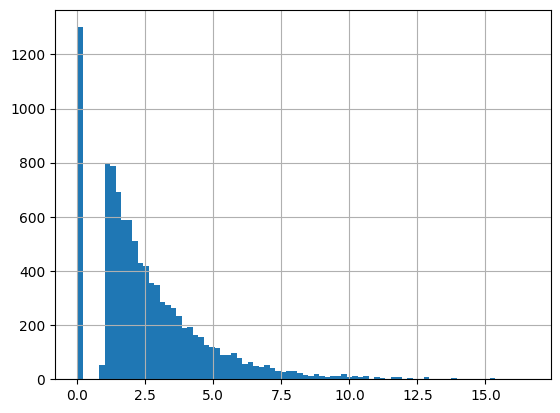

In [5]:
s = pd.Series(rvalues)
s.hist(bins='auto')

*Задание со звездочкой  : 
перерисовать гистограмму в логарифмической шкале. Сделать выводы. 
Получится прямая ?*
        

# Проверка различных стратегий

Все стратегии проверяются схожими по структуре функциями:

    - на вход подается массив исходов
    - на выходе массив возможных исходов

## Стратегия: постоянная ставка на некий коэффициент
Просто ставим 100  руб на постоянный коээфициент

In [6]:
@njit
def strategy_const_k (balance: float, k: float)  -> float:
    return k

Разовая симуляция для отладки (и вообще-то в numba хотя бы раз вызвать функцию для компиляции)

In [7]:
start_balance = 5000.0
game_rounds = 100 # продолжительность серии игры
rvalues = mult_values(0.13,game_rounds)
k=2.7

@njit
def simulate_one_game(start_balance: float, sequence: np.ndarray) -> float:
    balance = start_balance
    bet = 100 # постоянная сумма ставки 
    bet_rate = strategy_const_k(balance,k) # постоянная стратегия
    for outcome  in sequence:
        balance = balance - bet
        #print('prev:',balance,' ',end='')
        if outcome >= bet_rate and outcome >= 1.1 :
            balance += bet * bet_rate
        #print('outcome',outcome, 'new balance',balance)
    return balance

total = simulate_one_game(start_balance,rvalues)
print(total)

5530.0


Серия симуляций для выяснения **распределения** прогнозируемой суммы. 

In [24]:
game_rounds = 1000 # число подходов в одной игре, раз.
number_of_games = 100000 # число симуляций
game_results = np.zeros(number_of_games)

#@jit
def simulate_all_games ():
    for i in range(number_of_games):
        rvalues = mult_values(0.13,game_rounds)
        b = simulate_one_game(5000,rvalues)
        game_results[i]=simulate_one_game(5000,rvalues)

simulate_all_games()
# Контроль первых 10 результатов 
game_results[1:10]

array([ 4360.,  5170.,  6790., 12730.,  5170.,  8410.,  4360.,  4360.,
        3820.])

Теперь можно рассуждать об перспективах в игре с учетом **number_of_games** равновозможных вариантов будущего.

Ожидаемая сумма распределиться по этому графику:

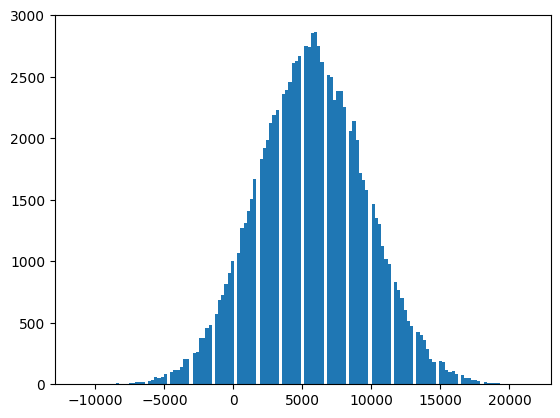

In [9]:
plt.hist(game_results,bins='auto');

In [10]:
print('Начали с ', start_balance, '. В среднем ожидаем выиграть', game_results.mean(), 
      ', но разброс +-',game_results.std())

Начали с  5000.0 . В среднем ожидаем выиграть 5645.3269 , но разброс +- 3950.584192893045


# Поиск оптимального коэффициента 

Зададим функцию для оптимизации. Пусть это будет  обратная от ожидаемого среднего

In [13]:
def find_function(x):
    # меняем глобальную k и перезапускам старую функцию
    k=x
    simulate_all_games()
    return -game_results.mean()
vfunc = np.vectorize(find_function)

Отрисуем график в некоторых точках чтобы понять с какой функцией имеем дело. Имеет ли смысл искать коэффициент вообще? 

In [17]:
xs = np.linspace(1.01,25,20)
xs

array([ 1.01      ,  2.27263158,  3.53526316,  4.79789474,  6.06052632,
        7.32315789,  8.58578947,  9.84842105, 11.11105263, 12.37368421,
       13.63631579, 14.89894737, 16.16157895, 17.42421053, 18.68684211,
       19.94947368, 21.21210526, 22.47473684, 23.73736842, 25.        ])

In [18]:
ys = vfunc(xs)
ys

array([-5633.8492, -5649.9358, -5667.1483, -5641.7143, -5665.1908,
       -5633.6845, -5639.8486, -5646.6337, -5679.6628, -5669.4487,
       -5646.145 , -5663.0524, -5655.0604, -5655.6544, -5645.5537,
       -5670.5692, -5645.0218, -5656.9909, -5655.8677, -5662.6717])

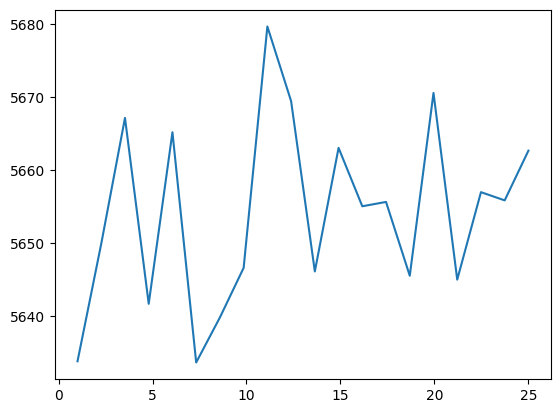

In [19]:
plt.plot(xs,-ys)

# Вывод:
бессмысленно искать минимум функции не заданной гладким образом, а полученной перемешиванием странных чисел

Используем стандартные функцию scipy
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize_scalar.html#scipy.optimize.minimize_scalar

In [20]:
from scipy.optimize import minimize_scalar

In [21]:
res = minimize_scalar(find_function, 1.5, bounds=(1.1, 50.0), method='bounded')
res

 message: Solution found.
 success: True
  status: 0
     fun: -5674.5571
       x: 27.048047474894283
     nit: 29
    nfev: 29